In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import skimage.data as data

from skimage.data import shepp_logan_phantom
from skimage.filters import *
from skimage.transform import radon, iradon, resize

random_generator = np.random.default_rng()

In [2]:
def get_mask(r = 1):
    x = y = np.arange(nx)
    xx, yy = np.meshgrid(x, y)
    
    return ((xx - nx/2)**2 + (yy - nx/2)**2 < (r * nx/2)**2).astype(float)

def get_image():
    u = 0.5 * np.float64(data.binary_blobs(length=nx, blob_size_fraction=0.5))
    u += 0.5 * np.float64(data.binary_blobs(length=nx, blob_size_fraction=0.2))
   
    mask = get_mask(r=0.9)
    u *= mask
   
    return u

nx = 200

image = get_image()
theta = np.linspace(0., 180., max(image.shape), endpoint=False)


# Function definitions used throughout the Notebook

In [3]:
def add_sinogram_noise(sinogram, I_0):
    I = random_generator.poisson(I_0 * np.exp(-sinogram))
    return -np.log(I / I_0)
    
    # Alternatively, we could approximate the Poisson distribution
    # by a Gaussian distribution. This gives more or less the same
    # result.
    # sinogram = random_generator.normal(
    #     sinogram, 1/ np.sqrt((I_0 * np.exp(-sinogram))))
    
def show_sinogram(ax, title_str, sinogram):
    ax.set_title(title_str)
    
    ax.set_xlabel("Projection angle (deg)")
    ax.set_ylabel("Projection position (pixels)")
    img_sinogram = ax.imshow(sinogram, 
                             cmap=plt.cm.Greys_r,
                             aspect='auto')
    plt.colorbar(img_sinogram, ax=ax, fraction=0.046, pad=0.04)

def show_image(ax, title_str, image):
    ax.set_title(title_str)
    img = ax.imshow(image, cmap=plt.cm.Greys_r, aspect='auto', 
                    vmin=-0.005, vmax=0.01
                   )
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)    
    
def show_transformed_sinogram(ax, title_str, transformed_sinogram):
    ax.set_title(f"{title_str} Fourier Transform")
    
    ax.set_xlabel("Projection angle (deg)")
    ax.set_ylabel("Frequency (probably wrong units)")
    transformed_img = ax.imshow(abs(transformed_sinogram), cmap=plt.cm.Greys_r, aspect='auto')
    plt.colorbar(transformed_img, ax=ax, fraction=0.046, pad=0.04)

In [4]:
from torch.utils.data import Dataset

class NumpyArrayDataset(Dataset):
    def __init__(self, path):
        self.npzfile = np.load(path)
        self.img_shape = self.npzfile[self.npzfile.files[0]][0].shape
    
    def __getitem__(self, idx):
        img = self.npzfile[self.npzfile.files[idx]].astype(np.single)
    
        entry = self.npzfile[self.npzfile.files[idx]]
    
        # For compatibility with the convolutional layers in the
        # network, we need to reshape the image to make it explicit 
        # that the image consists of one layer. 
        noisy_image = np.reshape(entry[0], (1, *self.img_shape))
        true_image  = np.reshape(entry[1], (1, *self.img_shape))
    
        # entry[0] is the noisy image, entry[1] is the true image. The
        # goal will be for the network to learn the mapping
        # noisy --> true.
        return (noisy_image.astype(np.single), true_image.astype(np.single))
    
    def __len__(self):
        return len(self.npzfile)
    
path = 'bachelorproject-code/shapes-dataset.npz'
shape_dataset = shapes_dataset = NumpyArrayDataset(path)

## Filter definitions

In [61]:
# Ramp filter. eps is not used.
def G_ramp(w, eps=0):
    return abs(w)

# Rectangle filter
def G_ram_lak(w, eps):
    w = abs(w)
    w[w > eps] = 0
    return w

# Truncated cosine
def G_cosine_t(w, eps):
    w = abs(w)
    w[w > eps] = 0
    return w * np.cos(np.pi * w / 2)

# Scaled cosine
def G_cosine_s(w, eps):
    w = abs(w)
    w[w > eps] = 0
    return w * np.cos(np.pi * w / (2 * eps))

# Truncated Shepp-Logan filter
def G_shepp_logan_t(w, eps):
    w = abs(w)
    w[w > eps] = 0
    return w * np.sinc(w)

# Scaled Shepp-Logan
def G_shepp_logan_s(w, eps):
    w = abs(w)
    w[w > eps] = 0
    return w * np.sinc(w / eps)

# Plotting different filters - Ramp, Ram-Lak, etc.

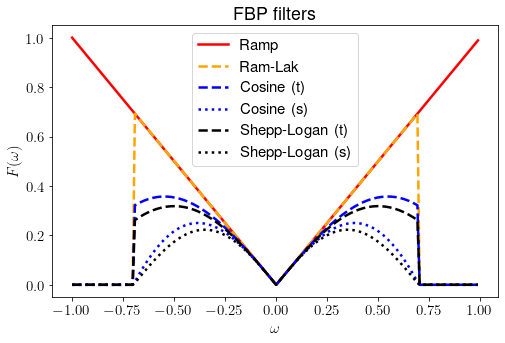

In [62]:
plt.figure(figsize=(8, 5))

plt.rcParams.update({"text.usetex": True, "font.size": 15})

ws = np.fft.fftshift(2 * np.fft.fftfreq(sinogram.shape[0]))
eps = 0.7

filter_list = [G_ramp, G_ram_lak, G_cosine_t, G_cosine_s, G_shepp_logan_t, G_shepp_logan_s]
name_list = ['Ramp', 'Ram-Lak', 'Cosine (t)', 'Cosine (s)', 'Shepp-Logan (t)', 'Shepp-Logan (s)']
color_list = ['red', 'orange', 'blue', 'blue', 'black', 'black']
style_list = ['solid', 'dashed', 'dashed', 'dotted', 'dashed', 'dotted']

for G, name, color, style in zip(filter_list, name_list, color_list, style_list):
    fs = G(ws, eps)
    plt.plot(ws, fs, label=name, c=color, ls=style, lw=2.5)
    
plt.legend()
plt.title('FBP filters')
plt.xlabel('$\omega$')
plt.ylabel('$F(\omega)$')
plt.savefig('low-pass-filters.png')

# Running the full process once - Radon, Filter, Back-Projection
Results from this cell are used in several places to avoid having to compute the same thing over and over.

In [87]:
noisy = True
title_str = "Noisy" if noisy else "Normal"

# The original image.

# img = 0.01 * get_mask(r=0.5)

img = resize(0.01 * shepp_logan_phantom(), (128, 128))
# img = shape_dataset[7][0][0]

# Perform the Radon Transformation
theta = np.linspace(0, 180, max(img.shape)//2, endpoint=False)
sinogram = radon(img, theta=theta, circle=False)

# Add noise if necessary
if noisy: 
    sinogram = add_sinogram_noise(sinogram, I_0 = 1000)

# Compute the Fourier Transform of the sinogram
transformed_sinogram = np.fft.fft(sinogram, axis=0)

# Apply the Ramp filter
filtered_transformed_sinogram = transformed_sinogram.copy()

height, width = filtered_transformed_sinogram.shape
for i in range(width):
    filtered_transformed_sinogram[:, i] *= 2 * G_ram_lak(np.fft.fftfreq(sinogram.shape[0]), 2)

# Back to the sensor domain
filtered_sinogram = np.fft.ifft(filtered_transformed_sinogram, axis=0)
assert np.isclose(filtered_sinogram.imag, 0).all()
filtered_sinogram = filtered_sinogram.real

# Compute the reconstruction
reconstruction = iradon(filtered_sinogram, theta=theta, 
                        filter_name=None, circle=False)

# Compute the error
error = reconstruction - img

# Plotting the results of the run

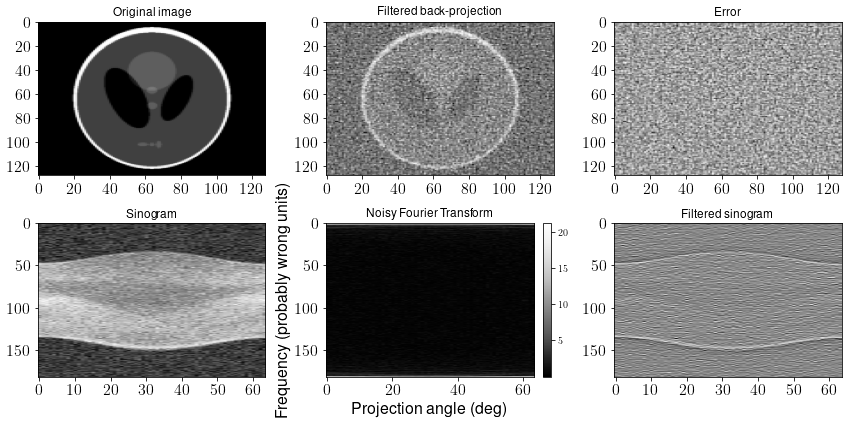

Error norm: 0.3542318095230343


In [88]:
# Make the plots.
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
plt.rcParams.update({'font.size': 10})

# First row:
show_image(               axs[0, 0], "Original image", img)
show_image(               axs[0, 1], "Filtered back-projection", reconstruction)
show_image(               axs[0, 2], "Error", error)

# Second row:
show_sinogram(            axs[1, 0], "Sinogram", sinogram)
show_transformed_sinogram(axs[1, 1], title_str, transformed_sinogram)
show_sinogram(            axs[1, 2], "Filtered sinogram", filtered_sinogram)

fig.tight_layout()
plt.show()

print(f"Error norm: {np.linalg.norm(error)}")

# Researching the effect of various windows on the FT of a sinogram

In [89]:
def plot_reconstruction_error_by_epss(transformed_sinogram, G, 
                                      filter_name, epss):
    """
    Draws a plot of the reconstruction error of FBP using the filter G
    """
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"],
        "font.size": 16})
    
    n = len(epss)
    num_cols = 4
    num_rows = (n + num_cols - 1) // num_cols
    
    reconstructions = [0 for _ in epss]
    errors = [0 for _ in epss]
    error_norms = [0 for _ in epss]
    
    for idx, eps in enumerate(epss):
        copied_fft = transformed_sinogram.copy()

        # Apply the Ramp filter
        height, width = copied_fft.shape
        for i in range(width):
            copied_fft[:, i] *= G(2 * np.fft.fftfreq(sinogram.shape[0]),
                                  eps)

        # Back to the sensor domain
        filtered_sinogram = np.fft.ifft(copied_fft, axis=0)
        assert np.isclose(filtered_sinogram.imag, 0).all()
        filtered_sinogram = filtered_sinogram.real

        # Compute the reconstruction
        reconstruction = iradon(filtered_sinogram, theta=theta, 
                                filter_name=None, circle=False)
        
        reconstructions[idx] = reconstruction
        # Compute the error
        error = reconstruction - img
        
        errors[idx] = error
        error_norms[idx] = np.linalg.norm(error)
        
    fig, axs = plt.subplots(n//4, 4, figsize=(num_cols * 4, num_rows * 4))
    print(f"Figsize: {(num_rows * 4, num_cols * 4)}")
        
    for idx, (eps, ax) in enumerate(zip(epss, fig.axes)):
        img_reconstruction = ax.imshow(reconstructions[idx], 
                                       cmap=plt.cm.Greys_r,
                                       aspect='auto',
#                                      vmin=-0.01, vmax=0.02
                                       )  
        
        # ax.set_title(f"$\log_{{10}}(\epsilon): {np.round(np.log10(eps), 2)}$")
        ax.set_title(f"$\epsilon = {np.round(eps, 2)}$")
        
        # Set up the color bar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(img_reconstruction, cax=cax)
        
    plt.tight_layout()
    plt.savefig('ramlak-filter-on-noisy-phantom.png')
    plt.show()

    plt.title(f"Reconstruction error for {filter_name} filter")
    plt.xlabel("$\epsilon$")
    plt.ylabel(r"$\Vert \mu - FBP[R[\mu]] \Vert$")
    plt.plot(epss, error_norms)
    

Figsize: (8, 16)


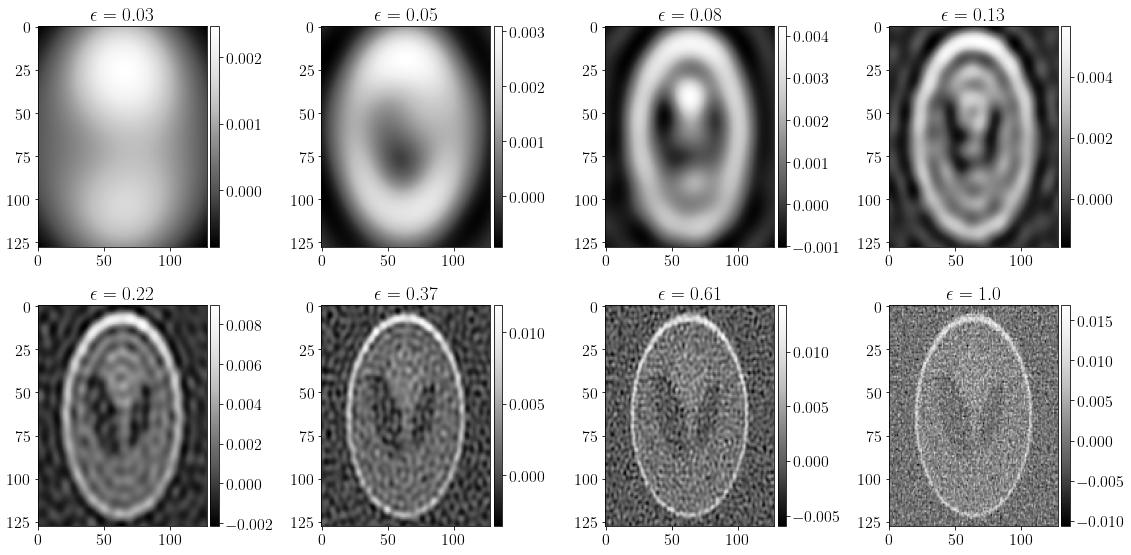

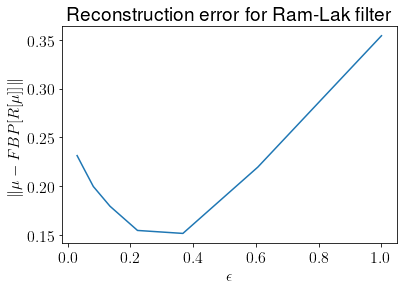

In [92]:
epss = np.logspace(np.log10(0.03), np.log10(1), 8)
plot_reconstruction_error_by_epss(transformed_sinogram, G_ram_lak, "Ram-Lak", epss)

# Plotting error norms for images in the shapes dataset

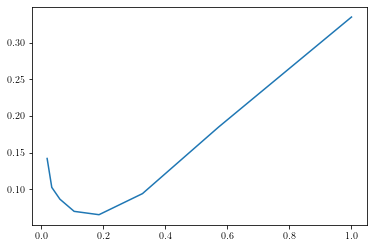

In [107]:
I_0 = 1000
G = G_ram_lak
num_images = 8

epss = np.logspace(np.log10(0.02), np.log10(1), 8)
error_norms = np.zeros((num_images, len(epss)), dtype=float)

for i in range(num_images):
    img = shapes_dataset[i][0][0]
    
    # Perform the Radon Transformation
    theta = np.linspace(0, 180, max(img.shape)//2, endpoint=False)
    sinogram = radon(img, theta=theta, circle=False)

    sinogram = add_sinogram_noise(sinogram, I_0=I_0)

    # Compute the Fourier Transform of the sinogram
    transformed_sinogram = np.fft.fft(sinogram, axis=0)

    # Up to this point, we hae not made use of the value of epsilon.
    # However, we are going to use it now, so this is where we start
    # looping over epsilon.
    
    for j, eps in enumerate(epss):
        # Apply the low-pass filter
        filtered_transformed_sinogram = transformed_sinogram.copy()

        height, width = filtered_transformed_sinogram.shape
        for k in range(width):
            filtered_transformed_sinogram[:, k] *= \
                G(2 * np.fft.fftfreq(sinogram.shape[0]), eps)

        # Back to the sensor domain
        filtered_sinogram = np.fft.ifft(filtered_transformed_sinogram, axis=0)
        assert np.isclose(filtered_sinogram.imag, 0).all()
        filtered_sinogram = filtered_sinogram.real

        # Compute the reconstruction
        reconstruction = iradon(filtered_sinogram, theta=theta, 
                                filter_name=None, circle=False)

        # Compute the error
        error = reconstruction - img
        
        error_norms[i, j] = np.linalg.norm(error)

plt.plot(epss, error_norms.mean(axis=0))

# Some additional plots for the W voortgangspresentatie

Error norm: 0.49468419468691976


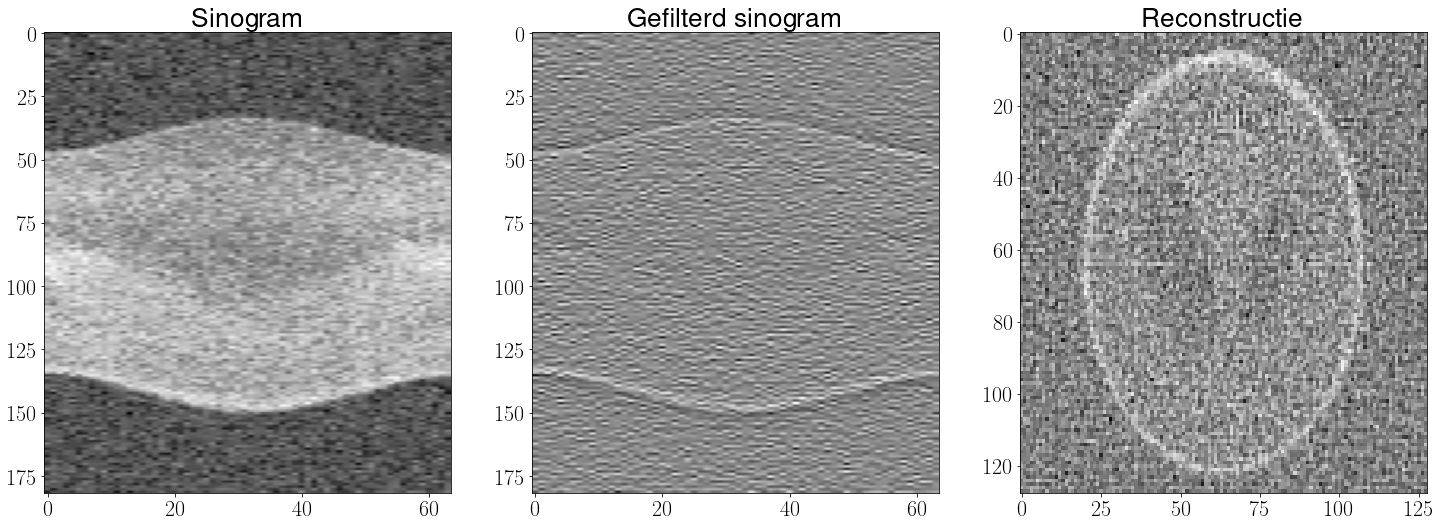

In [19]:
def show_sinogram(ax, title_str, sinogram):
    ax.set_title(title_str)
    
#     ax.set_xlabel("Hoek (graden)")
#     ax.set_ylabel("Positie (pixels)")
    img_sinogram = ax.imshow(sinogram, 
                             cmap=plt.cm.Greys_r,
                             aspect='auto')
#     plt.colorbar(img_sinogram, ax=ax, fraction=0.046, pad=0.04)

def show_image(ax, title_str, image):
    ax.set_title(title_str)
    img = ax.imshow(image, cmap=plt.cm.Greys_r, aspect='auto')
#     plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)    


plt.rcParams.update({'font.size': 22})

fig, axs = plt.subplots(1,3, figsize=(24, 8))
# plt.axis('off')

# First row:
show_image(               axs[2], "Reconstructie", reconstruction)

# Second row:
show_sinogram(            axs[0], "Sinogram", sinogram)
show_sinogram(            axs[1], "Gefilterd sinogram", filtered_sinogram)

fig.tight_layout()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)
plt.savefig('fbp-example-noisy.png')

print(f"Error norm: {np.linalg.norm(error)}")

Error norm: 0.49468419468691976


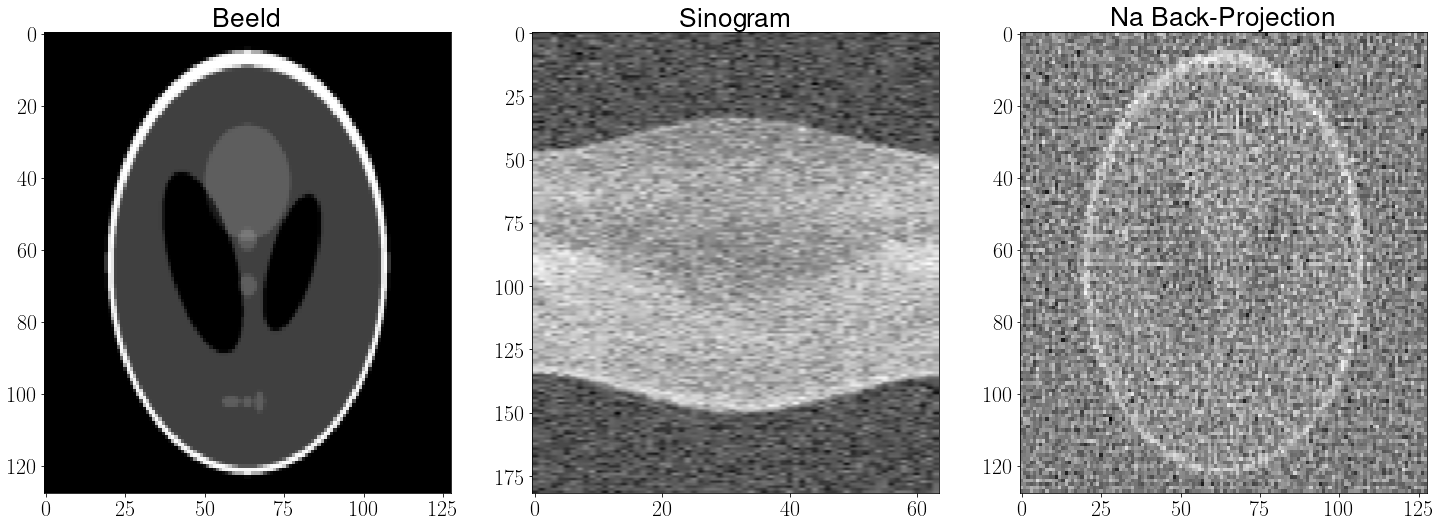

In [20]:
def show_sinogram(ax, title_str, sinogram):
    ax.set_title(title_str)
    
#     ax.set_xlabel("Hoek (graden)")
#     ax.set_ylabel("Positie (pixels)")
    img_sinogram = ax.imshow(sinogram, 
                             cmap=plt.cm.Greys_r,
                             aspect='auto')
#     plt.colorbar(img_sinogram, ax=ax, fraction=0.046, pad=0.04)

def show_image(ax, title_str, image):
    ax.set_title(title_str)
    img = ax.imshow(image, cmap=plt.cm.Greys_r, aspect='auto')
#     plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)    


plt.rcParams.update({'font.size': 22})

fig, axs = plt.subplots(1,3, figsize=(24, 8))
# plt.axis('off')

# First row:
show_image(               axs[0], "Beeld", img)

# Second row:
show_sinogram(            axs[1], "Sinogram", sinogram)
show_image(               axs[2], "Na Back-Projection", reconstruction)

fig.tight_layout()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)
plt.savefig('backprojection-no-filter.png')

print(f"Error norm: {np.linalg.norm(error)}")